In [186]:
import dlc_practical_prologue as prologue
#直接导入出现http403错误
from six.moves import urllib

In [187]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [188]:
# 直接导入出现http403错误
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [189]:
# load data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

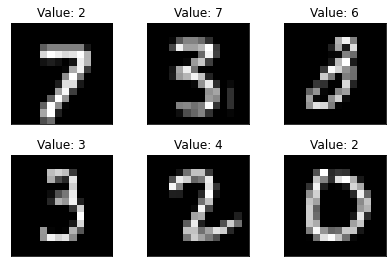

In [190]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray')
  plt.title("Value: {}".format(train_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [191]:
# plt.imshow(train_input[0][1],cmap='gray')
# plt.show()

In [192]:
print(train_input.shape)
print(train_input.dtype)
print(train_target.shape)
print(train_target.dtype)
print(train_classes.shape)
print(test_classes.shape)
print(train_classes[0])

torch.Size([1000, 2, 14, 14])
torch.float32
torch.Size([1000])
torch.int64
torch.Size([1000, 2])
torch.Size([1000, 2])
tensor([2, 2])


In [227]:
#weights_sharing_CNN
class CNN_Net_weight_sharing_auxiliary_loss(nn.Module):
    def __init__(self):
        super(CNN_Net_weight_sharing_auxiliary_loss, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5,stride=1, padding=2)
#         self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,128,kernel_size=2,stride=1, padding=2)
#         self.bn2 = nn.BatchNorm2d(128)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(3200, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(20,200)
        self.fc4 = nn.Linear(200,200)
        self.fc5 = nn.Linear(200,2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        
        img1 = x[:,0,:,:].view(-1,1,14,14)
        img2 = x[:,1,:,:].view(-1,1,14,14)
        # weight sharing
        img1 = F.relu(F.max_pool2d(self.conv1(img1), kernel_size=2, stride=2))
        img1 = F.relu(F.max_pool2d(self.conv2(img1), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv1(img2), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv2(img2), kernel_size=2, stride=2))
        print(img1.shape)
#       detect the img1 figure 
#         out1 = img1.reshape(img1.size(0), -1)
#         out1_1=img1.view(-1,512)
#         print(out1.shape)
#         print(out1_1.shape)
        output1 = F.relu(img1.view(-1,3200))
        output1 = F.relu(self.fc1(output1))
        output1 = F.relu(self.fc2(output1))
#       detect the img2 figure
        output2 = F.relu(img2.view(-1,3200))
        output2 = F.relu(self.fc1(output2))
        output2 = F.relu(self.fc2(output2))
#         print(output1.shape)
#         print(output2.shape)
        output = torch.cat((output1,output2),1)
        
        output = F.relu(self.fc3(output))
        output = F.relu(self.fc4(output))
        output = self.fc5(output)
        output = F.dropout(output,training=self.training)
        
        return output, output1, output2

        # Training Function with auxiliary_loss

    def trainer(self, train_input, train_target, train_classes):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        :output the loss plot
        """
        start_time = time.time()
        self.train()
        loss_history=[]
        for epoch in range(self.num_epochs):
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output, output1, output2 = self(train_input[batch_idx:batch_idx+self.batch_size])
                target = train_target[batch_idx:batch_idx+self.batch_size]
#                 print(output.shape)
#                 print(target.shape)
                class1 = train_classes[batch_idx:batch_idx+self.batch_size,0]
                class2 = train_classes[batch_idx:batch_idx+self.batch_size,1]
                loss = self.criterion(output, target)+0.5*self.criterion(output1, class1)+0.5*self.criterion(output2, class2)
#                 loss = self.criterion(output, target)
                self.optimizer.zero_grad()                          #清零梯度
                loss.backward()                                #反向求梯度
                self.optimizer.step()
#                 每隔50组数据，输出一次loss值
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
                if batch_idx == 950:
                    loss_history.append(loss)
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        plt.plot(loss_history)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Loss plot")
        plt.show()

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #test mode
        self.eval()
        errors = 0
        for idx in range(0,input_data.size(0),self.batch_size):
            input_batch=input_data.narrow(0,idx,self.batch_size)
            outputs,_,_ = self(input_batch)
            _, predicted = torch.max(outputs, 1)   #返回值和索引
            target_labels = target.narrow(0, idx, self.batch_size)
            errors += torch.sum(predicted != target_labels)

        return float(errors)*100/input_data.size(0)
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [228]:
my_model=CNN_Net_weight_sharing_auxiliary_loss()
my_model.save_model('CNN_Net_weight_sharing_auxiliary_loss.pth')

torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 000/1000 | Loss: 6.143881
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 050/1000 | Loss: 13.204754
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 100/1000 | Loss: 10.790336
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 150/1000 | Loss: 10.047630
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 200/1000 | Loss: 13.993513
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 250/1000 | Loss: 11.183495
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 300/1000 | Loss: 8.338141
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 350/1000 | Loss: 5.508938
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 400/1000 | Loss: 2.869962
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 450/1000 | Loss: 3.000273
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 500/1000 | Loss: 2.957564
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 550/1000 | Loss: 2.932166
torch.Size([50, 128, 5, 5])
Epoch: 001/025 | Batch 600/1000 | Loss: 2.9

Epoch: 006/025 | Batch 350/1000 | Loss: 2.389466
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 400/1000 | Loss: 2.559693
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 450/1000 | Loss: 2.380889
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 500/1000 | Loss: 2.763091
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 550/1000 | Loss: 2.627578
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 600/1000 | Loss: 2.582085
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 650/1000 | Loss: 2.547810
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 700/1000 | Loss: 2.415190
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 750/1000 | Loss: 2.273797
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 800/1000 | Loss: 2.502491
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 850/1000 | Loss: 2.417108
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 900/1000 | Loss: 2.428126
torch.Size([50, 128, 5, 5])
Epoch: 006/025 | Batch 950/1000 | Loss: 2.483912
Time elapsed: 0.15 min
torc

Epoch: 011/025 | Batch 700/1000 | Loss: 2.273429
torch.Size([50, 128, 5, 5])
Epoch: 011/025 | Batch 750/1000 | Loss: 2.253596
torch.Size([50, 128, 5, 5])
Epoch: 011/025 | Batch 800/1000 | Loss: 2.440247
torch.Size([50, 128, 5, 5])
Epoch: 011/025 | Batch 850/1000 | Loss: 2.336084
torch.Size([50, 128, 5, 5])
Epoch: 011/025 | Batch 900/1000 | Loss: 2.337169
torch.Size([50, 128, 5, 5])
Epoch: 011/025 | Batch 950/1000 | Loss: 2.366575
Time elapsed: 0.29 min
torch.Size([50, 128, 5, 5])
Epoch: 012/025 | Batch 000/1000 | Loss: 2.412175
torch.Size([50, 128, 5, 5])
Epoch: 012/025 | Batch 050/1000 | Loss: 2.484797
torch.Size([50, 128, 5, 5])
Epoch: 012/025 | Batch 100/1000 | Loss: 2.583709
torch.Size([50, 128, 5, 5])
Epoch: 012/025 | Batch 150/1000 | Loss: 2.402084
torch.Size([50, 128, 5, 5])
Epoch: 012/025 | Batch 200/1000 | Loss: 2.337698
torch.Size([50, 128, 5, 5])
Epoch: 012/025 | Batch 250/1000 | Loss: 2.626221
torch.Size([50, 128, 5, 5])
Epoch: 012/025 | Batch 300/1000 | Loss: 2.394852
torc

Epoch: 017/025 | Batch 050/1000 | Loss: 2.331074
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 100/1000 | Loss: 2.201199
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 150/1000 | Loss: 2.019456
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 200/1000 | Loss: 1.979313
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 250/1000 | Loss: 2.197213
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 300/1000 | Loss: 2.013544
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 350/1000 | Loss: 1.918792
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 400/1000 | Loss: 2.180689
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 450/1000 | Loss: 2.021785
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 500/1000 | Loss: 2.216089
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 550/1000 | Loss: 2.241701
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 600/1000 | Loss: 2.141436
torch.Size([50, 128, 5, 5])
Epoch: 017/025 | Batch 650/1000 | Loss: 2.110065
torch.Size([50, 128, 5, 5])

Epoch: 022/025 | Batch 350/1000 | Loss: 1.685181
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 400/1000 | Loss: 1.777117
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 450/1000 | Loss: 1.568358
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 500/1000 | Loss: 1.778780
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 550/1000 | Loss: 1.923485
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 600/1000 | Loss: 1.955166
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 650/1000 | Loss: 1.757079
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 700/1000 | Loss: 1.677047
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 750/1000 | Loss: 1.604808
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 800/1000 | Loss: 1.517722
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 850/1000 | Loss: 1.564154
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 900/1000 | Loss: 1.943066
torch.Size([50, 128, 5, 5])
Epoch: 022/025 | Batch 950/1000 | Loss: 1.863702
Time elapsed: 0.59 min
torc

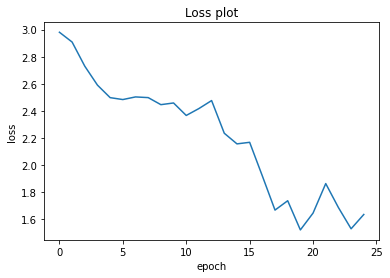

In [229]:
# train the model
my_model.trainer(train_input, train_target,train_classes)

In [215]:
# output the train error and test error
print("Train error : %.1f%% \nTest error : %.1f%%" %
      (my_model.compute_error(train_input, train_target),
       my_model.compute_error(test_input, test_target)))

print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

Train error : 43.0% 
Test error : 44.6%
The total number of the parameters is: 146700


Epoch: 001/025 | Batch 000/1000 | Loss: 1.362422
Epoch: 001/025 | Batch 050/1000 | Loss: 5.474372
Epoch: 001/025 | Batch 100/1000 | Loss: 2.253858
Epoch: 001/025 | Batch 150/1000 | Loss: 2.645154
Epoch: 001/025 | Batch 200/1000 | Loss: 1.572297
Epoch: 001/025 | Batch 250/1000 | Loss: 1.329137
Epoch: 001/025 | Batch 300/1000 | Loss: 0.901536
Epoch: 001/025 | Batch 350/1000 | Loss: 0.666545
Epoch: 001/025 | Batch 400/1000 | Loss: 0.721987
Epoch: 001/025 | Batch 450/1000 | Loss: 0.685706
Epoch: 001/025 | Batch 500/1000 | Loss: 0.695058
Epoch: 001/025 | Batch 550/1000 | Loss: 0.651118
Epoch: 001/025 | Batch 600/1000 | Loss: 0.689926
Epoch: 001/025 | Batch 650/1000 | Loss: 0.707605
Epoch: 001/025 | Batch 700/1000 | Loss: 0.685646
Epoch: 001/025 | Batch 750/1000 | Loss: 0.691498
Epoch: 001/025 | Batch 800/1000 | Loss: 0.683535
Epoch: 001/025 | Batch 850/1000 | Loss: 0.682333
Epoch: 001/025 | Batch 900/1000 | Loss: 0.672770
Epoch: 001/025 | Batch 950/1000 | Loss: 0.700939
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 400/1000 | Loss: 0.686383
Epoch: 009/025 | Batch 450/1000 | Loss: 0.689437
Epoch: 009/025 | Batch 500/1000 | Loss: 0.697694
Epoch: 009/025 | Batch 550/1000 | Loss: 0.630519
Epoch: 009/025 | Batch 600/1000 | Loss: 0.699955
Epoch: 009/025 | Batch 650/1000 | Loss: 0.692597
Epoch: 009/025 | Batch 700/1000 | Loss: 0.666642
Epoch: 009/025 | Batch 750/1000 | Loss: 0.704644
Epoch: 009/025 | Batch 800/1000 | Loss: 0.693899
Epoch: 009/025 | Batch 850/1000 | Loss: 0.665466
Epoch: 009/025 | Batch 900/1000 | Loss: 0.673247
Epoch: 009/025 | Batch 950/1000 | Loss: 0.708509
Time elapsed: 0.08 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.680893
Epoch: 010/025 | Batch 050/1000 | Loss: 0.672164
Epoch: 010/025 | Batch 100/1000 | Loss: 0.668965
Epoch: 010/025 | Batch 150/1000 | Loss: 0.692674
Epoch: 010/025 | Batch 200/1000 | Loss: 0.707048
Epoch: 010/025 | Batch 250/1000 | Loss: 0.691401
Epoch: 010/025 | Batch 300/1000 | Loss: 0.700642
Epoch: 010/025 | Batch 350/1000 | Loss: 0.7020

Epoch: 017/025 | Batch 950/1000 | Loss: 0.707085
Time elapsed: 0.14 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.683954
Epoch: 018/025 | Batch 050/1000 | Loss: 0.682708
Epoch: 018/025 | Batch 100/1000 | Loss: 0.673348
Epoch: 018/025 | Batch 150/1000 | Loss: 0.679999
Epoch: 018/025 | Batch 200/1000 | Loss: 0.696354
Epoch: 018/025 | Batch 250/1000 | Loss: 0.692946
Epoch: 018/025 | Batch 300/1000 | Loss: 0.677854
Epoch: 018/025 | Batch 350/1000 | Loss: 0.696769
Epoch: 018/025 | Batch 400/1000 | Loss: 0.690386
Epoch: 018/025 | Batch 450/1000 | Loss: 0.701730
Epoch: 018/025 | Batch 500/1000 | Loss: 0.702270
Epoch: 018/025 | Batch 550/1000 | Loss: 0.657742
Epoch: 018/025 | Batch 600/1000 | Loss: 0.713563
Epoch: 018/025 | Batch 650/1000 | Loss: 0.687786
Epoch: 018/025 | Batch 700/1000 | Loss: 0.678372
Epoch: 018/025 | Batch 750/1000 | Loss: 0.681632
Epoch: 018/025 | Batch 800/1000 | Loss: 0.681141
Epoch: 018/025 | Batch 850/1000 | Loss: 0.690543
Epoch: 018/025 | Batch 900/1000 | Loss: 0.6697

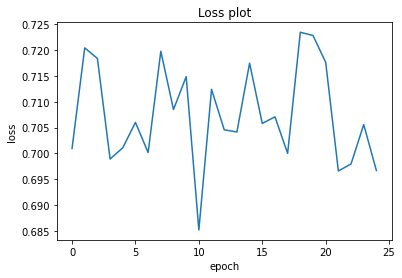

Epoch: 001/025 | Batch 000/1000 | Loss: 1.023849
Epoch: 001/025 | Batch 050/1000 | Loss: 9.641220
Epoch: 001/025 | Batch 100/1000 | Loss: 2.037254
Epoch: 001/025 | Batch 150/1000 | Loss: 0.763556
Epoch: 001/025 | Batch 200/1000 | Loss: 0.854082
Epoch: 001/025 | Batch 250/1000 | Loss: 0.706021
Epoch: 001/025 | Batch 300/1000 | Loss: 0.699214
Epoch: 001/025 | Batch 350/1000 | Loss: 0.706641
Epoch: 001/025 | Batch 400/1000 | Loss: 0.696844
Epoch: 001/025 | Batch 450/1000 | Loss: 0.701098
Epoch: 001/025 | Batch 500/1000 | Loss: 0.696153
Epoch: 001/025 | Batch 550/1000 | Loss: 0.702547
Epoch: 001/025 | Batch 600/1000 | Loss: 0.688888
Epoch: 001/025 | Batch 650/1000 | Loss: 0.697323
Epoch: 001/025 | Batch 700/1000 | Loss: 0.697410
Epoch: 001/025 | Batch 750/1000 | Loss: 0.696359
Epoch: 001/025 | Batch 800/1000 | Loss: 0.699113
Epoch: 001/025 | Batch 850/1000 | Loss: 0.695716
Epoch: 001/025 | Batch 900/1000 | Loss: 0.695682
Epoch: 001/025 | Batch 950/1000 | Loss: 0.693653
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 250/1000 | Loss: 0.690329
Epoch: 009/025 | Batch 300/1000 | Loss: 0.689812
Epoch: 009/025 | Batch 350/1000 | Loss: 0.683843
Epoch: 009/025 | Batch 400/1000 | Loss: 0.698554
Epoch: 009/025 | Batch 450/1000 | Loss: 0.687059
Epoch: 009/025 | Batch 500/1000 | Loss: 0.689141
Epoch: 009/025 | Batch 550/1000 | Loss: 0.682785
Epoch: 009/025 | Batch 600/1000 | Loss: 0.698616
Epoch: 009/025 | Batch 650/1000 | Loss: 0.686048
Epoch: 009/025 | Batch 700/1000 | Loss: 0.690297
Epoch: 009/025 | Batch 750/1000 | Loss: 0.688809
Epoch: 009/025 | Batch 800/1000 | Loss: 0.685002
Epoch: 009/025 | Batch 850/1000 | Loss: 0.686793
Epoch: 009/025 | Batch 900/1000 | Loss: 0.681027
Epoch: 009/025 | Batch 950/1000 | Loss: 0.689214
Time elapsed: 0.07 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.683817
Epoch: 010/025 | Batch 050/1000 | Loss: 0.698208
Epoch: 010/025 | Batch 100/1000 | Loss: 0.689934
Epoch: 010/025 | Batch 150/1000 | Loss: 0.701179
Epoch: 010/025 | Batch 200/1000 | Loss: 0.6885

Epoch: 017/025 | Batch 650/1000 | Loss: 0.688800
Epoch: 017/025 | Batch 700/1000 | Loss: 0.685143
Epoch: 017/025 | Batch 750/1000 | Loss: 0.685785
Epoch: 017/025 | Batch 800/1000 | Loss: 0.685365
Epoch: 017/025 | Batch 850/1000 | Loss: 0.694360
Epoch: 017/025 | Batch 900/1000 | Loss: 0.676189
Epoch: 017/025 | Batch 950/1000 | Loss: 0.681571
Time elapsed: 0.14 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.670799
Epoch: 018/025 | Batch 050/1000 | Loss: 0.697984
Epoch: 018/025 | Batch 100/1000 | Loss: 0.690164
Epoch: 018/025 | Batch 150/1000 | Loss: 0.714588
Epoch: 018/025 | Batch 200/1000 | Loss: 0.705272
Epoch: 018/025 | Batch 250/1000 | Loss: 0.687168
Epoch: 018/025 | Batch 300/1000 | Loss: 0.701762
Epoch: 018/025 | Batch 350/1000 | Loss: 0.668439
Epoch: 018/025 | Batch 400/1000 | Loss: 0.690707
Epoch: 018/025 | Batch 450/1000 | Loss: 0.674708
Epoch: 018/025 | Batch 500/1000 | Loss: 0.685303
Epoch: 018/025 | Batch 550/1000 | Loss: 0.687761
Epoch: 018/025 | Batch 600/1000 | Loss: 0.7174

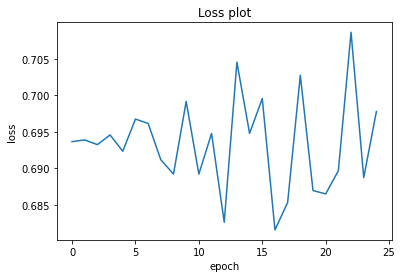

Epoch: 001/025 | Batch 000/1000 | Loss: 5.031866
Epoch: 001/025 | Batch 050/1000 | Loss: 1.584186
Epoch: 001/025 | Batch 100/1000 | Loss: 1.138884
Epoch: 001/025 | Batch 150/1000 | Loss: 0.800107
Epoch: 001/025 | Batch 200/1000 | Loss: 0.826513
Epoch: 001/025 | Batch 250/1000 | Loss: 0.893088
Epoch: 001/025 | Batch 300/1000 | Loss: 0.747277
Epoch: 001/025 | Batch 350/1000 | Loss: 0.689464
Epoch: 001/025 | Batch 400/1000 | Loss: 0.700037
Epoch: 001/025 | Batch 450/1000 | Loss: 0.692397
Epoch: 001/025 | Batch 500/1000 | Loss: 0.728499
Epoch: 001/025 | Batch 550/1000 | Loss: 0.736750
Epoch: 001/025 | Batch 600/1000 | Loss: 0.701943
Epoch: 001/025 | Batch 650/1000 | Loss: 0.688410
Epoch: 001/025 | Batch 700/1000 | Loss: 0.682270
Epoch: 001/025 | Batch 750/1000 | Loss: 0.700399
Epoch: 001/025 | Batch 800/1000 | Loss: 0.705063
Epoch: 001/025 | Batch 850/1000 | Loss: 0.739475
Epoch: 001/025 | Batch 900/1000 | Loss: 0.711944
Epoch: 001/025 | Batch 950/1000 | Loss: 0.717645
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 250/1000 | Loss: 0.701410
Epoch: 009/025 | Batch 300/1000 | Loss: 0.698539
Epoch: 009/025 | Batch 350/1000 | Loss: 0.692436
Epoch: 009/025 | Batch 400/1000 | Loss: 0.704528
Epoch: 009/025 | Batch 450/1000 | Loss: 0.695516
Epoch: 009/025 | Batch 500/1000 | Loss: 0.688928
Epoch: 009/025 | Batch 550/1000 | Loss: 0.680566
Epoch: 009/025 | Batch 600/1000 | Loss: 0.695104
Epoch: 009/025 | Batch 650/1000 | Loss: 0.684873
Epoch: 009/025 | Batch 700/1000 | Loss: 0.688242
Epoch: 009/025 | Batch 750/1000 | Loss: 0.688709
Epoch: 009/025 | Batch 800/1000 | Loss: 0.690888
Epoch: 009/025 | Batch 850/1000 | Loss: 0.695775
Epoch: 009/025 | Batch 900/1000 | Loss: 0.695536
Epoch: 009/025 | Batch 950/1000 | Loss: 0.673417
Time elapsed: 0.08 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.700772
Epoch: 010/025 | Batch 050/1000 | Loss: 0.681902
Epoch: 010/025 | Batch 100/1000 | Loss: 0.690756
Epoch: 010/025 | Batch 150/1000 | Loss: 0.688309
Epoch: 010/025 | Batch 200/1000 | Loss: 0.6941

Epoch: 017/025 | Batch 700/1000 | Loss: 0.685592
Epoch: 017/025 | Batch 750/1000 | Loss: 0.691753
Epoch: 017/025 | Batch 800/1000 | Loss: 0.697347
Epoch: 017/025 | Batch 850/1000 | Loss: 0.685207
Epoch: 017/025 | Batch 900/1000 | Loss: 0.703104
Epoch: 017/025 | Batch 950/1000 | Loss: 0.683167
Time elapsed: 0.16 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.709721
Epoch: 018/025 | Batch 050/1000 | Loss: 0.692677
Epoch: 018/025 | Batch 100/1000 | Loss: 0.681198
Epoch: 018/025 | Batch 150/1000 | Loss: 0.683102
Epoch: 018/025 | Batch 200/1000 | Loss: 0.685797
Epoch: 018/025 | Batch 250/1000 | Loss: 0.684492
Epoch: 018/025 | Batch 300/1000 | Loss: 0.696179
Epoch: 018/025 | Batch 350/1000 | Loss: 0.684849
Epoch: 018/025 | Batch 400/1000 | Loss: 0.682937
Epoch: 018/025 | Batch 450/1000 | Loss: 0.690044
Epoch: 018/025 | Batch 500/1000 | Loss: 0.694960
Epoch: 018/025 | Batch 550/1000 | Loss: 0.693792
Epoch: 018/025 | Batch 600/1000 | Loss: 0.703152
Epoch: 018/025 | Batch 650/1000 | Loss: 0.6945

Epoch: 025/025 | Batch 950/1000 | Loss: 0.679409
Time elapsed: 0.24 min
Total Training Time: 0.24 min


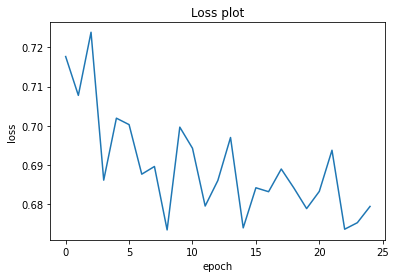

Epoch: 001/025 | Batch 000/1000 | Loss: 2.501253
Epoch: 001/025 | Batch 050/1000 | Loss: 6.404135
Epoch: 001/025 | Batch 100/1000 | Loss: 1.425967
Epoch: 001/025 | Batch 150/1000 | Loss: 2.150954
Epoch: 001/025 | Batch 200/1000 | Loss: 1.844414
Epoch: 001/025 | Batch 250/1000 | Loss: 0.981327
Epoch: 001/025 | Batch 300/1000 | Loss: 0.663512
Epoch: 001/025 | Batch 350/1000 | Loss: 0.693314
Epoch: 001/025 | Batch 400/1000 | Loss: 0.728484
Epoch: 001/025 | Batch 450/1000 | Loss: 0.733335
Epoch: 001/025 | Batch 500/1000 | Loss: 0.671820
Epoch: 001/025 | Batch 550/1000 | Loss: 0.685584
Epoch: 001/025 | Batch 600/1000 | Loss: 0.746303
Epoch: 001/025 | Batch 650/1000 | Loss: 0.706727
Epoch: 001/025 | Batch 700/1000 | Loss: 0.710540
Epoch: 001/025 | Batch 750/1000 | Loss: 0.685469
Epoch: 001/025 | Batch 800/1000 | Loss: 0.690451
Epoch: 001/025 | Batch 850/1000 | Loss: 0.729727
Epoch: 001/025 | Batch 900/1000 | Loss: 0.713108
Epoch: 001/025 | Batch 950/1000 | Loss: 0.706190
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 500/1000 | Loss: 0.680330
Epoch: 009/025 | Batch 550/1000 | Loss: 0.705657
Epoch: 009/025 | Batch 600/1000 | Loss: 0.711761
Epoch: 009/025 | Batch 650/1000 | Loss: 0.704469
Epoch: 009/025 | Batch 700/1000 | Loss: 0.714239
Epoch: 009/025 | Batch 750/1000 | Loss: 0.697771
Epoch: 009/025 | Batch 800/1000 | Loss: 0.706531
Epoch: 009/025 | Batch 850/1000 | Loss: 0.706679
Epoch: 009/025 | Batch 900/1000 | Loss: 0.703314
Epoch: 009/025 | Batch 950/1000 | Loss: 0.703038
Time elapsed: 0.09 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.690961
Epoch: 010/025 | Batch 050/1000 | Loss: 0.696251
Epoch: 010/025 | Batch 100/1000 | Loss: 0.710894
Epoch: 010/025 | Batch 150/1000 | Loss: 0.698521
Epoch: 010/025 | Batch 200/1000 | Loss: 0.711553
Epoch: 010/025 | Batch 250/1000 | Loss: 0.692494
Epoch: 010/025 | Batch 300/1000 | Loss: 0.699134
Epoch: 010/025 | Batch 350/1000 | Loss: 0.696768
Epoch: 010/025 | Batch 400/1000 | Loss: 0.682793
Epoch: 010/025 | Batch 450/1000 | Loss: 0.6961

Epoch: 017/025 | Batch 750/1000 | Loss: 0.699364
Epoch: 017/025 | Batch 800/1000 | Loss: 0.690580
Epoch: 017/025 | Batch 850/1000 | Loss: 0.692235
Epoch: 017/025 | Batch 900/1000 | Loss: 0.690141
Epoch: 017/025 | Batch 950/1000 | Loss: 0.693501
Time elapsed: 0.17 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.700559
Epoch: 018/025 | Batch 050/1000 | Loss: 0.685148
Epoch: 018/025 | Batch 100/1000 | Loss: 0.693454
Epoch: 018/025 | Batch 150/1000 | Loss: 0.690489
Epoch: 018/025 | Batch 200/1000 | Loss: 0.698004
Epoch: 018/025 | Batch 250/1000 | Loss: 0.695182
Epoch: 018/025 | Batch 300/1000 | Loss: 0.689544
Epoch: 018/025 | Batch 350/1000 | Loss: 0.690588
Epoch: 018/025 | Batch 400/1000 | Loss: 0.700584
Epoch: 018/025 | Batch 450/1000 | Loss: 0.700585
Epoch: 018/025 | Batch 500/1000 | Loss: 0.694629
Epoch: 018/025 | Batch 550/1000 | Loss: 0.690432
Epoch: 018/025 | Batch 600/1000 | Loss: 0.695384
Epoch: 018/025 | Batch 650/1000 | Loss: 0.676262
Epoch: 018/025 | Batch 700/1000 | Loss: 0.6784

Epoch: 025/025 | Batch 950/1000 | Loss: 0.697393
Time elapsed: 0.25 min
Total Training Time: 0.25 min


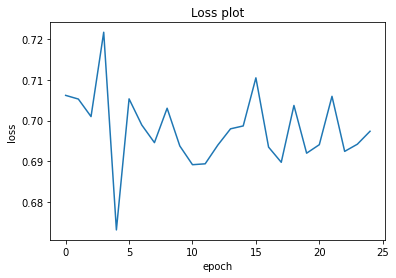

Epoch: 001/025 | Batch 000/1000 | Loss: 1.898641
Epoch: 001/025 | Batch 050/1000 | Loss: 2.409612
Epoch: 001/025 | Batch 100/1000 | Loss: 1.175020
Epoch: 001/025 | Batch 150/1000 | Loss: 0.891394
Epoch: 001/025 | Batch 200/1000 | Loss: 0.735777
Epoch: 001/025 | Batch 250/1000 | Loss: 0.688686
Epoch: 001/025 | Batch 300/1000 | Loss: 0.684294
Epoch: 001/025 | Batch 350/1000 | Loss: 0.691797
Epoch: 001/025 | Batch 400/1000 | Loss: 0.696562
Epoch: 001/025 | Batch 450/1000 | Loss: 0.700146
Epoch: 001/025 | Batch 500/1000 | Loss: 0.686101
Epoch: 001/025 | Batch 550/1000 | Loss: 0.695598
Epoch: 001/025 | Batch 600/1000 | Loss: 0.696142
Epoch: 001/025 | Batch 650/1000 | Loss: 0.687906
Epoch: 001/025 | Batch 700/1000 | Loss: 0.693717
Epoch: 001/025 | Batch 750/1000 | Loss: 0.691515
Epoch: 001/025 | Batch 800/1000 | Loss: 0.693062
Epoch: 001/025 | Batch 850/1000 | Loss: 0.695778
Epoch: 001/025 | Batch 900/1000 | Loss: 0.687764
Epoch: 001/025 | Batch 950/1000 | Loss: 0.684439
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 450/1000 | Loss: 0.690013
Epoch: 009/025 | Batch 500/1000 | Loss: 0.698595
Epoch: 009/025 | Batch 550/1000 | Loss: 0.686391
Epoch: 009/025 | Batch 600/1000 | Loss: 0.693114
Epoch: 009/025 | Batch 650/1000 | Loss: 0.694324
Epoch: 009/025 | Batch 700/1000 | Loss: 0.674837
Epoch: 009/025 | Batch 750/1000 | Loss: 0.676464
Epoch: 009/025 | Batch 800/1000 | Loss: 0.703752
Epoch: 009/025 | Batch 850/1000 | Loss: 0.693139
Epoch: 009/025 | Batch 900/1000 | Loss: 0.694224
Epoch: 009/025 | Batch 950/1000 | Loss: 0.693907
Time elapsed: 0.09 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.682616
Epoch: 010/025 | Batch 050/1000 | Loss: 0.673962
Epoch: 010/025 | Batch 100/1000 | Loss: 0.682600
Epoch: 010/025 | Batch 150/1000 | Loss: 0.693113
Epoch: 010/025 | Batch 200/1000 | Loss: 0.677691
Epoch: 010/025 | Batch 250/1000 | Loss: 0.681430
Epoch: 010/025 | Batch 300/1000 | Loss: 0.673162
Epoch: 010/025 | Batch 350/1000 | Loss: 0.657312
Epoch: 010/025 | Batch 400/1000 | Loss: 0.6648

Epoch: 017/025 | Batch 750/1000 | Loss: 0.683731
Epoch: 017/025 | Batch 800/1000 | Loss: 0.716813
Epoch: 017/025 | Batch 850/1000 | Loss: 0.668225
Epoch: 017/025 | Batch 900/1000 | Loss: 0.693253
Epoch: 017/025 | Batch 950/1000 | Loss: 0.680761
Time elapsed: 0.17 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.657127
Epoch: 018/025 | Batch 050/1000 | Loss: 0.673469
Epoch: 018/025 | Batch 100/1000 | Loss: 0.681038
Epoch: 018/025 | Batch 150/1000 | Loss: 0.698095
Epoch: 018/025 | Batch 200/1000 | Loss: 0.711220
Epoch: 018/025 | Batch 250/1000 | Loss: 0.702764
Epoch: 018/025 | Batch 300/1000 | Loss: 0.681415
Epoch: 018/025 | Batch 350/1000 | Loss: 0.669924
Epoch: 018/025 | Batch 400/1000 | Loss: 0.698896
Epoch: 018/025 | Batch 450/1000 | Loss: 0.676046
Epoch: 018/025 | Batch 500/1000 | Loss: 0.671357
Epoch: 018/025 | Batch 550/1000 | Loss: 0.692276
Epoch: 018/025 | Batch 600/1000 | Loss: 0.693308
Epoch: 018/025 | Batch 650/1000 | Loss: 0.706095
Epoch: 018/025 | Batch 700/1000 | Loss: 0.6686

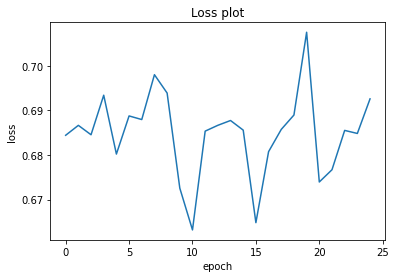

Epoch: 001/025 | Batch 000/1000 | Loss: 1.841283
Epoch: 001/025 | Batch 050/1000 | Loss: 4.322476
Epoch: 001/025 | Batch 100/1000 | Loss: 0.791685
Epoch: 001/025 | Batch 150/1000 | Loss: 2.298759
Epoch: 001/025 | Batch 200/1000 | Loss: 1.470317
Epoch: 001/025 | Batch 250/1000 | Loss: 1.329893
Epoch: 001/025 | Batch 300/1000 | Loss: 1.068178
Epoch: 001/025 | Batch 350/1000 | Loss: 0.781536
Epoch: 001/025 | Batch 400/1000 | Loss: 0.651691
Epoch: 001/025 | Batch 450/1000 | Loss: 0.799613
Epoch: 001/025 | Batch 500/1000 | Loss: 0.620597
Epoch: 001/025 | Batch 550/1000 | Loss: 0.928113
Epoch: 001/025 | Batch 600/1000 | Loss: 0.660297
Epoch: 001/025 | Batch 650/1000 | Loss: 0.655902
Epoch: 001/025 | Batch 700/1000 | Loss: 0.676037
Epoch: 001/025 | Batch 750/1000 | Loss: 0.767439
Epoch: 001/025 | Batch 800/1000 | Loss: 0.703343
Epoch: 001/025 | Batch 850/1000 | Loss: 0.765367
Epoch: 001/025 | Batch 900/1000 | Loss: 0.697826
Epoch: 001/025 | Batch 950/1000 | Loss: 0.923770
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 200/1000 | Loss: 0.701948
Epoch: 009/025 | Batch 250/1000 | Loss: 0.689038
Epoch: 009/025 | Batch 300/1000 | Loss: 0.674661
Epoch: 009/025 | Batch 350/1000 | Loss: 0.694155
Epoch: 009/025 | Batch 400/1000 | Loss: 0.692348
Epoch: 009/025 | Batch 450/1000 | Loss: 0.697887
Epoch: 009/025 | Batch 500/1000 | Loss: 0.698358
Epoch: 009/025 | Batch 550/1000 | Loss: 0.687384
Epoch: 009/025 | Batch 600/1000 | Loss: 0.687743
Epoch: 009/025 | Batch 650/1000 | Loss: 0.690938
Epoch: 009/025 | Batch 700/1000 | Loss: 0.681310
Epoch: 009/025 | Batch 750/1000 | Loss: 0.696431
Epoch: 009/025 | Batch 800/1000 | Loss: 0.692614
Epoch: 009/025 | Batch 850/1000 | Loss: 0.693718
Epoch: 009/025 | Batch 900/1000 | Loss: 0.683971
Epoch: 009/025 | Batch 950/1000 | Loss: 0.685961
Time elapsed: 0.10 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.685749
Epoch: 010/025 | Batch 050/1000 | Loss: 0.704287
Epoch: 010/025 | Batch 100/1000 | Loss: 0.687859
Epoch: 010/025 | Batch 150/1000 | Loss: 0.6970

Epoch: 017/025 | Batch 450/1000 | Loss: 0.707470
Epoch: 017/025 | Batch 500/1000 | Loss: 0.703880
Epoch: 017/025 | Batch 550/1000 | Loss: 0.701684
Epoch: 017/025 | Batch 600/1000 | Loss: 0.683658
Epoch: 017/025 | Batch 650/1000 | Loss: 0.683694
Epoch: 017/025 | Batch 700/1000 | Loss: 0.681737
Epoch: 017/025 | Batch 750/1000 | Loss: 0.688958
Epoch: 017/025 | Batch 800/1000 | Loss: 0.691866
Epoch: 017/025 | Batch 850/1000 | Loss: 0.697204
Epoch: 017/025 | Batch 900/1000 | Loss: 0.705019
Epoch: 017/025 | Batch 950/1000 | Loss: 0.671509
Time elapsed: 0.21 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.696881
Epoch: 018/025 | Batch 050/1000 | Loss: 0.690072
Epoch: 018/025 | Batch 100/1000 | Loss: 0.701761
Epoch: 018/025 | Batch 150/1000 | Loss: 0.689324
Epoch: 018/025 | Batch 200/1000 | Loss: 0.698250
Epoch: 018/025 | Batch 250/1000 | Loss: 0.695042
Epoch: 018/025 | Batch 300/1000 | Loss: 0.696889
Epoch: 018/025 | Batch 350/1000 | Loss: 0.692700
Epoch: 018/025 | Batch 400/1000 | Loss: 0.6966

Epoch: 025/025 | Batch 850/1000 | Loss: 0.695906
Epoch: 025/025 | Batch 900/1000 | Loss: 0.694873
Epoch: 025/025 | Batch 950/1000 | Loss: 0.683841
Time elapsed: 0.32 min
Total Training Time: 0.32 min


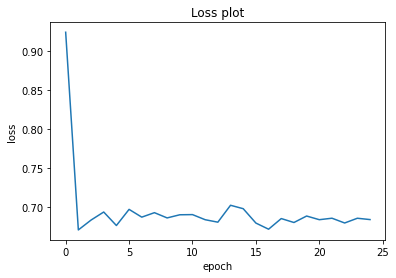

Epoch: 001/025 | Batch 000/1000 | Loss: 1.968170
Epoch: 001/025 | Batch 050/1000 | Loss: 6.716924
Epoch: 001/025 | Batch 100/1000 | Loss: 1.090730
Epoch: 001/025 | Batch 150/1000 | Loss: 7.218502
Epoch: 001/025 | Batch 200/1000 | Loss: 2.033464
Epoch: 001/025 | Batch 250/1000 | Loss: 2.249823
Epoch: 001/025 | Batch 300/1000 | Loss: 1.401655
Epoch: 001/025 | Batch 350/1000 | Loss: 1.449102
Epoch: 001/025 | Batch 400/1000 | Loss: 1.441442
Epoch: 001/025 | Batch 450/1000 | Loss: 1.087137
Epoch: 001/025 | Batch 500/1000 | Loss: 1.073272
Epoch: 001/025 | Batch 550/1000 | Loss: 1.030843
Epoch: 001/025 | Batch 600/1000 | Loss: 0.710504
Epoch: 001/025 | Batch 650/1000 | Loss: 0.646030
Epoch: 001/025 | Batch 700/1000 | Loss: 0.669709
Epoch: 001/025 | Batch 750/1000 | Loss: 0.635716
Epoch: 001/025 | Batch 800/1000 | Loss: 0.718560
Epoch: 001/025 | Batch 850/1000 | Loss: 0.657069
Epoch: 001/025 | Batch 900/1000 | Loss: 0.625056
Epoch: 001/025 | Batch 950/1000 | Loss: 0.668815
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 350/1000 | Loss: 0.660246
Epoch: 009/025 | Batch 400/1000 | Loss: 0.613395
Epoch: 009/025 | Batch 450/1000 | Loss: 0.608615
Epoch: 009/025 | Batch 500/1000 | Loss: 0.627661
Epoch: 009/025 | Batch 550/1000 | Loss: 0.631896
Epoch: 009/025 | Batch 600/1000 | Loss: 0.583031
Epoch: 009/025 | Batch 650/1000 | Loss: 0.499956
Epoch: 009/025 | Batch 700/1000 | Loss: 0.509263
Epoch: 009/025 | Batch 750/1000 | Loss: 0.575177
Epoch: 009/025 | Batch 800/1000 | Loss: 0.533989
Epoch: 009/025 | Batch 850/1000 | Loss: 0.428976
Epoch: 009/025 | Batch 900/1000 | Loss: 0.460185
Epoch: 009/025 | Batch 950/1000 | Loss: 0.622635
Time elapsed: 0.12 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.556814
Epoch: 010/025 | Batch 050/1000 | Loss: 0.604634
Epoch: 010/025 | Batch 100/1000 | Loss: 0.468161
Epoch: 010/025 | Batch 150/1000 | Loss: 0.607133
Epoch: 010/025 | Batch 200/1000 | Loss: 0.570264
Epoch: 010/025 | Batch 250/1000 | Loss: 0.655702
Epoch: 010/025 | Batch 300/1000 | Loss: 0.5848

Epoch: 017/025 | Batch 550/1000 | Loss: 0.428360
Epoch: 017/025 | Batch 600/1000 | Loss: 0.474174
Epoch: 017/025 | Batch 650/1000 | Loss: 0.373128
Epoch: 017/025 | Batch 700/1000 | Loss: 0.408363
Epoch: 017/025 | Batch 750/1000 | Loss: 0.450461
Epoch: 017/025 | Batch 800/1000 | Loss: 0.450494
Epoch: 017/025 | Batch 850/1000 | Loss: 0.393563
Epoch: 017/025 | Batch 900/1000 | Loss: 0.402429
Epoch: 017/025 | Batch 950/1000 | Loss: 0.461321
Time elapsed: 0.21 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.430954
Epoch: 018/025 | Batch 050/1000 | Loss: 0.375435
Epoch: 018/025 | Batch 100/1000 | Loss: 0.330081
Epoch: 018/025 | Batch 150/1000 | Loss: 0.327357
Epoch: 018/025 | Batch 200/1000 | Loss: 0.334581
Epoch: 018/025 | Batch 250/1000 | Loss: 0.366451
Epoch: 018/025 | Batch 300/1000 | Loss: 0.492270
Epoch: 018/025 | Batch 350/1000 | Loss: 0.462674
Epoch: 018/025 | Batch 400/1000 | Loss: 0.377519
Epoch: 018/025 | Batch 450/1000 | Loss: 0.343420
Epoch: 018/025 | Batch 500/1000 | Loss: 0.3433

Epoch: 025/025 | Batch 800/1000 | Loss: 0.225612
Epoch: 025/025 | Batch 850/1000 | Loss: 0.101235
Epoch: 025/025 | Batch 900/1000 | Loss: 0.116263
Epoch: 025/025 | Batch 950/1000 | Loss: 0.169927
Time elapsed: 0.31 min
Total Training Time: 0.31 min


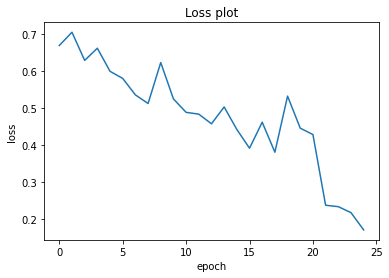

Epoch: 001/025 | Batch 000/1000 | Loss: 1.505528
Epoch: 001/025 | Batch 050/1000 | Loss: 3.429275
Epoch: 001/025 | Batch 100/1000 | Loss: 2.589213
Epoch: 001/025 | Batch 150/1000 | Loss: 1.508051
Epoch: 001/025 | Batch 200/1000 | Loss: 1.449603
Epoch: 001/025 | Batch 250/1000 | Loss: 0.643237
Epoch: 001/025 | Batch 300/1000 | Loss: 0.741403
Epoch: 001/025 | Batch 350/1000 | Loss: 0.748210
Epoch: 001/025 | Batch 400/1000 | Loss: 0.692008
Epoch: 001/025 | Batch 450/1000 | Loss: 0.715036
Epoch: 001/025 | Batch 500/1000 | Loss: 0.705782
Epoch: 001/025 | Batch 550/1000 | Loss: 0.716485
Epoch: 001/025 | Batch 600/1000 | Loss: 0.712258
Epoch: 001/025 | Batch 650/1000 | Loss: 0.692825
Epoch: 001/025 | Batch 700/1000 | Loss: 0.707346
Epoch: 001/025 | Batch 750/1000 | Loss: 0.712682
Epoch: 001/025 | Batch 800/1000 | Loss: 0.699048
Epoch: 001/025 | Batch 850/1000 | Loss: 0.716225
Epoch: 001/025 | Batch 900/1000 | Loss: 0.715079
Epoch: 001/025 | Batch 950/1000 | Loss: 0.695771
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 200/1000 | Loss: 0.702548
Epoch: 009/025 | Batch 250/1000 | Loss: 0.691878
Epoch: 009/025 | Batch 300/1000 | Loss: 0.689348
Epoch: 009/025 | Batch 350/1000 | Loss: 0.687802
Epoch: 009/025 | Batch 400/1000 | Loss: 0.699787
Epoch: 009/025 | Batch 450/1000 | Loss: 0.707293
Epoch: 009/025 | Batch 500/1000 | Loss: 0.709458
Epoch: 009/025 | Batch 550/1000 | Loss: 0.687327
Epoch: 009/025 | Batch 600/1000 | Loss: 0.700369
Epoch: 009/025 | Batch 650/1000 | Loss: 0.701804
Epoch: 009/025 | Batch 700/1000 | Loss: 0.698517
Epoch: 009/025 | Batch 750/1000 | Loss: 0.682470
Epoch: 009/025 | Batch 800/1000 | Loss: 0.701253
Epoch: 009/025 | Batch 850/1000 | Loss: 0.711296
Epoch: 009/025 | Batch 900/1000 | Loss: 0.679492
Epoch: 009/025 | Batch 950/1000 | Loss: 0.695934
Time elapsed: 0.10 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.701997
Epoch: 010/025 | Batch 050/1000 | Loss: 0.709405
Epoch: 010/025 | Batch 100/1000 | Loss: 0.699451
Epoch: 010/025 | Batch 150/1000 | Loss: 0.6955

Epoch: 017/025 | Batch 450/1000 | Loss: 0.702349
Epoch: 017/025 | Batch 500/1000 | Loss: 0.702967
Epoch: 017/025 | Batch 550/1000 | Loss: 0.690273
Epoch: 017/025 | Batch 600/1000 | Loss: 0.690262
Epoch: 017/025 | Batch 650/1000 | Loss: 0.694004
Epoch: 017/025 | Batch 700/1000 | Loss: 0.677011
Epoch: 017/025 | Batch 750/1000 | Loss: 0.705648
Epoch: 017/025 | Batch 800/1000 | Loss: 0.691346
Epoch: 017/025 | Batch 850/1000 | Loss: 0.691293
Epoch: 017/025 | Batch 900/1000 | Loss: 0.679130
Epoch: 017/025 | Batch 950/1000 | Loss: 0.677195
Time elapsed: 0.18 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.684454
Epoch: 018/025 | Batch 050/1000 | Loss: 0.696193
Epoch: 018/025 | Batch 100/1000 | Loss: 0.695305
Epoch: 018/025 | Batch 150/1000 | Loss: 0.678995
Epoch: 018/025 | Batch 200/1000 | Loss: 0.702175
Epoch: 018/025 | Batch 250/1000 | Loss: 0.682153
Epoch: 018/025 | Batch 300/1000 | Loss: 0.698715
Epoch: 018/025 | Batch 350/1000 | Loss: 0.645732
Epoch: 018/025 | Batch 400/1000 | Loss: 0.6810

Epoch: 025/025 | Batch 850/1000 | Loss: 0.689904
Epoch: 025/025 | Batch 900/1000 | Loss: 0.691394
Epoch: 025/025 | Batch 950/1000 | Loss: 0.699421
Time elapsed: 0.26 min
Total Training Time: 0.26 min


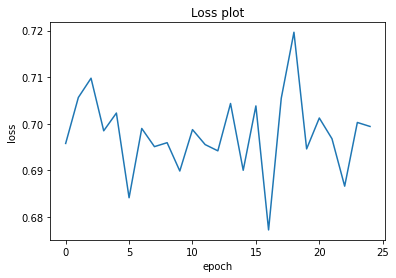

Epoch: 001/025 | Batch 000/1000 | Loss: 1.927634
Epoch: 001/025 | Batch 050/1000 | Loss: 9.857878
Epoch: 001/025 | Batch 100/1000 | Loss: 2.841725
Epoch: 001/025 | Batch 150/1000 | Loss: 1.242854
Epoch: 001/025 | Batch 200/1000 | Loss: 0.866938
Epoch: 001/025 | Batch 250/1000 | Loss: 0.672349
Epoch: 001/025 | Batch 300/1000 | Loss: 0.748353
Epoch: 001/025 | Batch 350/1000 | Loss: 0.826517
Epoch: 001/025 | Batch 400/1000 | Loss: 0.758464
Epoch: 001/025 | Batch 450/1000 | Loss: 0.767764
Epoch: 001/025 | Batch 500/1000 | Loss: 0.736927
Epoch: 001/025 | Batch 550/1000 | Loss: 0.750915
Epoch: 001/025 | Batch 600/1000 | Loss: 0.674832
Epoch: 001/025 | Batch 650/1000 | Loss: 0.825390
Epoch: 001/025 | Batch 700/1000 | Loss: 0.684465
Epoch: 001/025 | Batch 750/1000 | Loss: 0.747728
Epoch: 001/025 | Batch 800/1000 | Loss: 0.647127
Epoch: 001/025 | Batch 850/1000 | Loss: 0.642200
Epoch: 001/025 | Batch 900/1000 | Loss: 0.542696
Epoch: 001/025 | Batch 950/1000 | Loss: 0.684888
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 350/1000 | Loss: 0.300108
Epoch: 009/025 | Batch 400/1000 | Loss: 0.375224
Epoch: 009/025 | Batch 450/1000 | Loss: 0.281314
Epoch: 009/025 | Batch 500/1000 | Loss: 0.229426
Epoch: 009/025 | Batch 550/1000 | Loss: 0.293165
Epoch: 009/025 | Batch 600/1000 | Loss: 0.282716
Epoch: 009/025 | Batch 650/1000 | Loss: 0.295665
Epoch: 009/025 | Batch 700/1000 | Loss: 0.221943
Epoch: 009/025 | Batch 750/1000 | Loss: 0.199918
Epoch: 009/025 | Batch 800/1000 | Loss: 0.249845
Epoch: 009/025 | Batch 850/1000 | Loss: 0.386406
Epoch: 009/025 | Batch 900/1000 | Loss: 0.307137
Epoch: 009/025 | Batch 950/1000 | Loss: 0.355870
Time elapsed: 0.09 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.218883
Epoch: 010/025 | Batch 050/1000 | Loss: 0.337740
Epoch: 010/025 | Batch 100/1000 | Loss: 0.298846
Epoch: 010/025 | Batch 150/1000 | Loss: 0.271903
Epoch: 010/025 | Batch 200/1000 | Loss: 0.262064
Epoch: 010/025 | Batch 250/1000 | Loss: 0.336651
Epoch: 010/025 | Batch 300/1000 | Loss: 0.2838

Epoch: 017/025 | Batch 800/1000 | Loss: 0.172719
Epoch: 017/025 | Batch 850/1000 | Loss: 0.225019
Epoch: 017/025 | Batch 900/1000 | Loss: 0.218935
Epoch: 017/025 | Batch 950/1000 | Loss: 0.225137
Time elapsed: 0.17 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.154676
Epoch: 018/025 | Batch 050/1000 | Loss: 0.241421
Epoch: 018/025 | Batch 100/1000 | Loss: 0.236860
Epoch: 018/025 | Batch 150/1000 | Loss: 0.122200
Epoch: 018/025 | Batch 200/1000 | Loss: 0.234904
Epoch: 018/025 | Batch 250/1000 | Loss: 0.188685
Epoch: 018/025 | Batch 300/1000 | Loss: 0.176485
Epoch: 018/025 | Batch 350/1000 | Loss: 0.193159
Epoch: 018/025 | Batch 400/1000 | Loss: 0.242347
Epoch: 018/025 | Batch 450/1000 | Loss: 0.147994
Epoch: 018/025 | Batch 500/1000 | Loss: 0.221936
Epoch: 018/025 | Batch 550/1000 | Loss: 0.285377
Epoch: 018/025 | Batch 600/1000 | Loss: 0.174464
Epoch: 018/025 | Batch 650/1000 | Loss: 0.220827
Epoch: 018/025 | Batch 700/1000 | Loss: 0.301987
Epoch: 018/025 | Batch 750/1000 | Loss: 0.2216

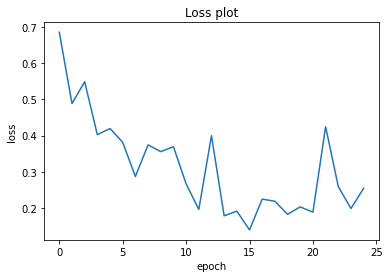

Epoch: 001/025 | Batch 000/1000 | Loss: 4.767028
Epoch: 001/025 | Batch 050/1000 | Loss: 2.268857
Epoch: 001/025 | Batch 100/1000 | Loss: 1.326654
Epoch: 001/025 | Batch 150/1000 | Loss: 0.686937
Epoch: 001/025 | Batch 200/1000 | Loss: 0.682777
Epoch: 001/025 | Batch 250/1000 | Loss: 0.742113
Epoch: 001/025 | Batch 300/1000 | Loss: 0.674322
Epoch: 001/025 | Batch 350/1000 | Loss: 0.684468
Epoch: 001/025 | Batch 400/1000 | Loss: 0.631813
Epoch: 001/025 | Batch 450/1000 | Loss: 0.620232
Epoch: 001/025 | Batch 500/1000 | Loss: 0.624777
Epoch: 001/025 | Batch 550/1000 | Loss: 0.594068
Epoch: 001/025 | Batch 600/1000 | Loss: 0.623208
Epoch: 001/025 | Batch 650/1000 | Loss: 0.590521
Epoch: 001/025 | Batch 700/1000 | Loss: 0.640458
Epoch: 001/025 | Batch 750/1000 | Loss: 0.597926
Epoch: 001/025 | Batch 800/1000 | Loss: 0.567695
Epoch: 001/025 | Batch 850/1000 | Loss: 0.485422
Epoch: 001/025 | Batch 900/1000 | Loss: 0.715908
Epoch: 001/025 | Batch 950/1000 | Loss: 0.548875
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 250/1000 | Loss: 0.245780
Epoch: 009/025 | Batch 300/1000 | Loss: 0.281360
Epoch: 009/025 | Batch 350/1000 | Loss: 0.227037
Epoch: 009/025 | Batch 400/1000 | Loss: 0.249240
Epoch: 009/025 | Batch 450/1000 | Loss: 0.302028
Epoch: 009/025 | Batch 500/1000 | Loss: 0.328427
Epoch: 009/025 | Batch 550/1000 | Loss: 0.297519
Epoch: 009/025 | Batch 600/1000 | Loss: 0.238018
Epoch: 009/025 | Batch 650/1000 | Loss: 0.294977
Epoch: 009/025 | Batch 700/1000 | Loss: 0.236127
Epoch: 009/025 | Batch 750/1000 | Loss: 0.260883
Epoch: 009/025 | Batch 800/1000 | Loss: 0.287908
Epoch: 009/025 | Batch 850/1000 | Loss: 0.269755
Epoch: 009/025 | Batch 900/1000 | Loss: 0.267185
Epoch: 009/025 | Batch 950/1000 | Loss: 0.369104
Time elapsed: 0.09 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.303822
Epoch: 010/025 | Batch 050/1000 | Loss: 0.258810
Epoch: 010/025 | Batch 100/1000 | Loss: 0.403485
Epoch: 010/025 | Batch 150/1000 | Loss: 0.301681
Epoch: 010/025 | Batch 200/1000 | Loss: 0.2505

Epoch: 017/025 | Batch 500/1000 | Loss: 0.158618
Epoch: 017/025 | Batch 550/1000 | Loss: 0.219987
Epoch: 017/025 | Batch 600/1000 | Loss: 0.251337
Epoch: 017/025 | Batch 650/1000 | Loss: 0.250181
Epoch: 017/025 | Batch 700/1000 | Loss: 0.250355
Epoch: 017/025 | Batch 750/1000 | Loss: 0.094654
Epoch: 017/025 | Batch 800/1000 | Loss: 0.204487
Epoch: 017/025 | Batch 850/1000 | Loss: 0.165866
Epoch: 017/025 | Batch 900/1000 | Loss: 0.227107
Epoch: 017/025 | Batch 950/1000 | Loss: 0.230576
Time elapsed: 0.17 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.296166
Epoch: 018/025 | Batch 050/1000 | Loss: 0.167362
Epoch: 018/025 | Batch 100/1000 | Loss: 0.168375
Epoch: 018/025 | Batch 150/1000 | Loss: 0.189235
Epoch: 018/025 | Batch 200/1000 | Loss: 0.180390
Epoch: 018/025 | Batch 250/1000 | Loss: 0.252224
Epoch: 018/025 | Batch 300/1000 | Loss: 0.141255
Epoch: 018/025 | Batch 350/1000 | Loss: 0.191580
Epoch: 018/025 | Batch 400/1000 | Loss: 0.201883
Epoch: 018/025 | Batch 450/1000 | Loss: 0.1644

Epoch: 025/025 | Batch 700/1000 | Loss: 0.236326
Epoch: 025/025 | Batch 750/1000 | Loss: 0.085360
Epoch: 025/025 | Batch 800/1000 | Loss: 0.194750
Epoch: 025/025 | Batch 850/1000 | Loss: 0.208210
Epoch: 025/025 | Batch 900/1000 | Loss: 0.195808
Epoch: 025/025 | Batch 950/1000 | Loss: 0.140022
Time elapsed: 0.25 min
Total Training Time: 0.25 min


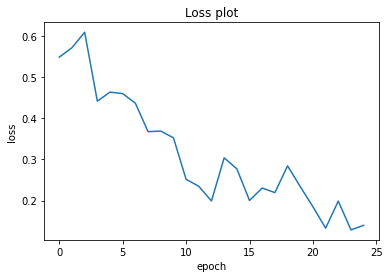

In [216]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net_weight_sharing()
    # train the model
    my_model.trainer(train_input, train_target,train_classes)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [217]:
print('The standard deviation of train error:',np.std(np.divide(train_errors, 100)))
print('The standard deviation of test error:',np.std(np.divide(test_errors, 100)))
print('The mean of train error: %.1f%%'%np.mean(train_errors))
print('The mean of test error: %.1f%%'%np.mean(test_errors))

The standard deviation of train error: 0.20123717350430065
The standard deviation of test error: 0.13926912795016705
The mean of train error: 31.5%
The mean of test error: 36.3%
